# original warper - with slow matplotlib-plot transformer

In [5]:
from sympy import symbols, lambdify, sin, cos, tanh, exp, log, Max
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import _cntr as cntr
from mpl_toolkits.mplot3d import Axes3D
import math
import time
from ipywidgets import interact
from ipywidgets import widgets

class warper:
    
    def __init__(self):
        a = 0
        self.orig_data = []
        self.transformed_data = []
        self.original_separator = []
        self.transformed_separator = []
        self.labels = []
        self.ind0 = []
        self.ind1 = []
        self.grid = []
        
    # define the user-defined transformation in numpy
    def define_rule(self,rule1,rule2):
        self.rule1 = lambdify((x1,x2),rule1,np)
        self.rule2 = lambdify((x1,x2),rule2,np)

    # transform data bsaed on user-defined transformations
    def make_rule(self,data):
        s = data[:,0]
        t = data[:,1]

        ## transform space - each axes - via net transform    
        f1 = self.rule1(s,t)
        f1.shape = (len(f1),1)

        # transform using basis element 2
        f2 = self.rule2(s,t)
        f2.shape = (len(f2),1)

        return f1,f2
    
    # create points based on user-defined transformations
    def make_pts(self):
        # generate datapoints based on user-defined rule
        r = np.linspace(-10.1,10.1,2000)
        s,t = np.meshgrid(r,r)
        s = np.reshape(s,(np.size(s),1))
        t = np.reshape(t,(np.size(t),1))
        h = np.concatenate((s,t),axis = 1)

        # use rule to partition the input space
        f1,f2 = self.make_rule(h)

        # cut the space to make this rule
        z = f1 + f2
        z = (np.sign(z))
        s.shape = (np.size(r),np.size(r))
        t.shape = (np.size(r),np.size(r))
        z.shape = (np.size(r),np.size(r))
        
        ## build dataset based on this rule
        num_pts = 200   # number of points for dataset
        X = -5 + 10*np.random.rand(num_pts,2)
        g1,g2 = self.make_rule(X)
        pts = g1 + g2

        ind0 = np.argwhere(pts <= 0)
        ind0 = [v[0] for v in ind0]
        ind1 = np.argwhere(pts > 0)
        ind1 = [v[0] for v in ind1]

        y = np.zeros((num_pts,1))
        y[ind0] = -1
        y[ind1] = 1

        # form transformed dataset
        T = np.concatenate((g1,g2),axis = 1)

        # store original and transformed data
        self.orig_data = X
        self.transformed_data = T
        self.labels = y
        self.ind0 = ind0
        self.ind1 = ind1
        
        # now that points are stored, we can make a warpable grid
        self.make_warpable_grid()

    # make the adjustable grid
    def make_warpable_grid(self):
        # define range of grid
        horz_max = max(max(self.orig_data[:,0]),max(self.transformed_data[:,0]))
        horz_min = min(min(self.orig_data[:,0]),min(self.transformed_data[:,0]))
        
        vert_max = max(max(self.transformed_data[:,1]),max(self.transformed_data[:,1]))
        vert_min = min(min(self.orig_data[:,1]),min(self.transformed_data[:,1]))
        
        s = np.linspace(-10,10,40)
        s.shape = (len(s),1)
        g = np.array([-10,-10])
        g.shape = (1,len(g))
        e = np.linspace(-10,10,200)
        e.shape = (len(e),1)
        f = np.ones((200,1))
        f.shape = (len(f),1)
        for a in s:
            t = a*f
            h = np.concatenate((e,t),axis = 1)
            i = np.concatenate((t,e),axis = 1)
            j = np.concatenate((h,i),axis = 0)
            g = np.concatenate((g,j),axis = 0)

        self.grid = g[1:,:]
        
    # plot the before data, separator, and grid
    def show_before_picture(self):
        # make figure
        fig = plt.figure(figsize = (5,5))
        ax1 = fig.add_subplot(111)          # panel for original space
        
        ### plot original data and separator
        r = np.linspace(-5.1,5.1,2000)
        s,t = np.meshgrid(r,r)
        s = np.reshape(s,(np.size(s),1))
        t = np.reshape(t,(np.size(t),1))
        h = np.concatenate((s,t),axis = 1)

        # use rule to partition the input space
        f1,f2 = self.make_rule(h)
        z = f1 + f2
        z = (np.sign(z))
        s.shape = (np.size(r),np.size(r))
        t.shape = (np.size(r),np.size(r))
        z.shape = (np.size(r),np.size(r))
        
        # plot points and separator
        self.plot_pts(self.orig_data,ax1)
        self.plot_separator(s,t,z,ax1)
        ax1.set_xlim([-5.3,5.3])
        ax1.set_ylim([-5.3,5.3])

        # plot grid
        grid1 = self.grid
        self.plot_grid(grid1,ax1)
        ax1.axis('off')
        
    # create the figure 
    def show_before_and_after(self):
        # make figure
        fig = plt.figure(figsize = (10,5))
        ax1 = fig.add_subplot(121)          # panel for original space
        ax2 = fig.add_subplot(122)          # panel transformed space
        
        ### plot original data and separator
        r = np.linspace(-5.1,5.1,2000)
        s,t = np.meshgrid(r,r)
        s = np.reshape(s,(np.size(s),1))
        t = np.reshape(t,(np.size(t),1))
        h = np.concatenate((s,t),axis = 1)

        # use rule to partition the input space
        f1,f2 = self.make_rule(h)
        z = f1 + f2
        z = (np.sign(z))
        s.shape = (np.size(r),np.size(r))
        t.shape = (np.size(r),np.size(r))
        z.shape = (np.size(r),np.size(r))
        
        # plot points and separator
        self.plot_pts(self.orig_data,ax1)
        self.plot_separator(s,t,z,ax1)
        ax1.set_xlim([-5.3,5.3])
        ax1.set_ylim([-5.3,5.3])
        ax1.axis('off')
        
        # plot grid
        grid1 = self.grid
        self.plot_grid(grid1,ax1)
        
        ### plot transformed data and separator
        f1.shape = (np.size(r),np.size(r))
        f2.shape = (np.size(r),np.size(r))
        self.plot_separator(f1,f2,z,ax2)
        self.plot_pts(self.transformed_data,ax2)
        
        # plot grid        
        grida,gridb = self.make_rule(self.grid)
        grid2 = np.concatenate((grida,gridb),axis = 1)
        self.plot_grid(grid2,ax2)
        T = self.transformed_data
        hgap = (max(T[:,0]) - min(T[:,0]))*0.05
        vgap = (max(T[:,1]) - min(T[:,1]))*0.05
        ax2.set_xlim([min(T[:,0])-hgap,max(T[:,0])+hgap])
        ax2.set_ylim([min(T[:,1])-vgap,max(T[:,1])+vgap])
        ax2.axis('off')
        
    # plot current separator
    def plot_separator(self,x,y,z,ax):
        # plot rule in original and transformed spaces
        ax.contour(x,y,z,colors='k', linewidths=2.0,levels = [0],zorder = 2)
        
    # plot points
    def plot_pts(self,data,ax):
        # custom colors
        red = [0.25,1,0.5]    # custom color for plotting purposes
        green = [1,0.3,0.3]   # custom color for plotting purposes
        
        # plot points on desired panel
        ax.scatter(data[self.ind0,0],data[self.ind0,1],s = 50, color = green, edgecolor = 'k')
        ax.scatter(data[self.ind1,0],data[self.ind1,1],s = 50, color = red, edgecolor = 'k')

    # plot adjustble grid
    def plot_grid(self,grid,ax):
        for i in range(80):
            ax.plot(grid[200*i:(i+1)*200,0],grid[200*i:(i+1)*200,1],color = [0.75,0.75,0.75],linewidth = 1,zorder = 0)   
        
    # show the net transformation using slider
    def transformation_slider(self):  
        
        # make points start and end
        X1 = self.orig_data
        X2 = self.transformed_data
        
        # make separator start and end
        r = np.linspace(-10.1,10.1,2000)
        s,t = np.meshgrid(r,r)
        s = np.reshape(s,(np.size(s),1))
        t = np.reshape(t,(np.size(t),1))
        h = np.concatenate((s,t),axis = 1)

        # use rule to partition the input space
        f1,f2 = self.make_rule(h)
        z = f1 + f2
        z = (np.sign(z))
        s.shape = (np.size(r),np.size(r))
        t.shape = (np.size(r),np.size(r))
        z.shape = (np.size(r),np.size(r))
        f1.shape = (np.size(r),np.size(r))
        f2.shape = (np.size(r),np.size(r))
        
        # make grid start and end 
        grid1 = self.grid
        grida,gridb = self.make_rule(self.grid)
        grid2 = np.concatenate((grida,gridb),axis = 1)
            
        def show_fit(p):
            # make figure
            fig = plt.figure(figsize = (5,5))
            ax1 = fig.add_subplot(111)          # panel for original space
            ax1.axis('off')
   
            # make alpha
            alpha = p/float(300)

            # setup current points and print
            T = (1-alpha)*X1 + alpha*X2
            self.plot_pts(T,ax1)
            
            # setup separator and print
            sep1 = (1-alpha)*s + alpha*f1
            sep2 = (1-alpha)*t + alpha*f2
            self.plot_separator(sep1,sep2,z,ax1)
            
            # setup current grid and print
            grid = (1-alpha)*grid1 + alpha*grid2
            self.plot_grid(grid,ax1)
            
            # set axis limits for current dataset
            hgap = (max(T[:,0]) - min(T[:,0]))*0.05
            vgap = (max(T[:,1]) - min(T[:,1]))*0.05
            ax1.set_xlim([min(T[:,0])-hgap,max(T[:,0])+hgap])
            ax1.set_ylim([min(T[:,1])-vgap,max(T[:,1])+vgap])
                               
        interact(show_fit, p=widgets.IntSlider(min=0,max=300,step=1,value=0))

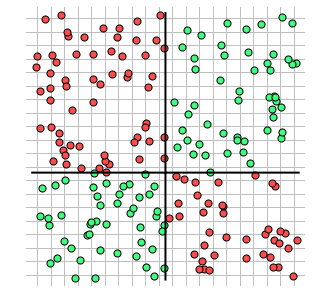

In [11]:
# make instance of warper
demo = warper()

from sympy import symbols, lambdify, sin, cos, tanh, exp, log, Max
x1,x2 = symbols('x1 x2')
rule1 = x1*x2
rule2 = x1
demo.define_rule(rule1,rule2)
demo.make_pts()
demo.show_before_picture()

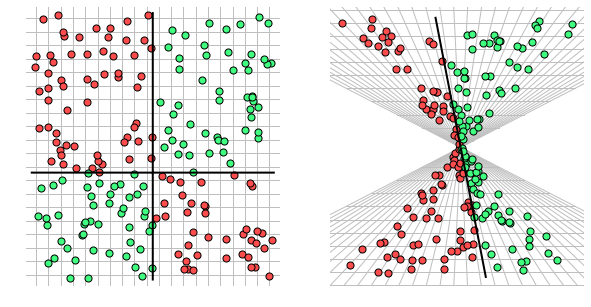

In [12]:
demo.show_before_and_after()

# Integrate bokeh animation into warper - test 1: make contours actively while slider-ing

In [81]:
from sympy import symbols, lambdify, sin, cos, tanh, exp, log, Max
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import _cntr as cntr

from mpl_toolkits.mplot3d import Axes3D
import math
import time
from ipywidgets import interact
from ipywidgets import widgets

from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
from bokeh.palettes import Spectral11
output_notebook()
from ipywidgets import interact

class warper2:
    
    def __init__(self):
        a = 0
        self.orig_data = []
        self.transformed_data = []
        self.original_separator = []
        self.transformed_separator = []
        self.labels = []
        self.ind0 = []
        self.ind1 = []
        self.grid = []
        
    # define the user-defined transformation in numpy
    def define_rule(self,rule1,rule2):
        self.rule1 = lambdify((x1,x2),rule1,np)
        self.rule2 = lambdify((x1,x2),rule2,np)

    # transform data bsaed on user-defined transformations
    def make_rule(self,data):
        s = data[:,0]
        t = data[:,1]

        ## transform space - each axes - via net transform    
        f1 = self.rule1(s,t)
        f1.shape = (len(f1),1)

        # transform using basis element 2
        f2 = self.rule2(s,t)
        f2.shape = (len(f2),1)

        return f1,f2
    
    # create points based on user-defined transformations
    def make_pts(self):
        # generate datapoints based on user-defined rule
        r = np.linspace(-10.1,10.1,2000)
        s,t = np.meshgrid(r,r)
        s = np.reshape(s,(np.size(s),1))
        t = np.reshape(t,(np.size(t),1))
        h = np.concatenate((s,t),axis = 1)

        # use rule to partition the input space
        f1,f2 = self.make_rule(h)

        # cut the space to make this rule
        z = f1 + f2
        z = (np.sign(z))
        s.shape = (np.size(r),np.size(r))
        t.shape = (np.size(r),np.size(r))
        z.shape = (np.size(r),np.size(r))
        
        ## build dataset based on this rule
        num_pts = 200   # number of points for dataset
        X = -5 + 10*np.random.rand(num_pts,2)
        g1,g2 = self.make_rule(X)
        pts = g1 + g2

        ind0 = np.argwhere(pts <= 0)
        ind0 = [v[0] for v in ind0]
        ind1 = np.argwhere(pts > 0)
        ind1 = [v[0] for v in ind1]

        y = np.zeros((num_pts,1))
        y[ind0] = -1
        y[ind1] = 1

        # form transformed dataset
        T = np.concatenate((g1,g2),axis = 1)

        # store original and transformed data
        self.orig_data = X
        self.transformed_data = T
        self.labels = y
        self.ind0 = ind0
        self.ind1 = ind1
        
        # now that points are stored, we can make a warpable grid
        self.make_warpable_grid()

    # make the adjustable grid
    def make_warpable_grid(self):
        # define range of grid
        horz_max = max(max(self.orig_data[:,0]),max(self.transformed_data[:,0]))
        horz_min = min(min(self.orig_data[:,0]),min(self.transformed_data[:,0]))
        
        vert_max = max(max(self.transformed_data[:,1]),max(self.transformed_data[:,1]))
        vert_min = min(min(self.orig_data[:,1]),min(self.transformed_data[:,1]))
        
        s = np.linspace(-10,10,40)
        s.shape = (len(s),1)
        g = np.array([-10,-10])
        g.shape = (1,len(g))
        e = np.linspace(-10,10,200)
        e.shape = (len(e),1)
        f = np.ones((200,1))
        f.shape = (len(f),1)
        for a in s:
            t = a*f
            h = np.concatenate((e,t),axis = 1)
            i = np.concatenate((t,e),axis = 1)
            j = np.concatenate((h,i),axis = 0)
            g = np.concatenate((g,j),axis = 0)

        self.grid = g[1:,:]
        
    # plot the before data, separator, and grid
    def show_before_picture(self):
        # make figure
        fig = plt.figure(figsize = (5,5))
        ax1 = fig.add_subplot(111)          # panel for original space
        
        ### plot original data and separator
        r = np.linspace(-5.1,5.1,2000)
        s,t = np.meshgrid(r,r)
        s = np.reshape(s,(np.size(s),1))
        t = np.reshape(t,(np.size(t),1))
        h = np.concatenate((s,t),axis = 1)

        # use rule to partition the input space
        f1,f2 = self.make_rule(h)
        z = f1 + f2
        z = (np.sign(z))
        s.shape = (np.size(r),np.size(r))
        t.shape = (np.size(r),np.size(r))
        z.shape = (np.size(r),np.size(r))
        
        # plot points and separator
        self.plot_pts(self.orig_data,ax1)
        self.plot_separator(s,t,z,ax1)
        ax1.set_xlim([-5.3,5.3])
        ax1.set_ylim([-5.3,5.3])

        # plot grid
        grid1 = self.grid
        self.plot_grid(grid1,ax1)
        ax1.axis('off')
        
    # create the figure 
    def show_before_and_after(self):
        # make figure
        fig = plt.figure(figsize = (10,5))
        ax1 = fig.add_subplot(121)          # panel for original space
        ax2 = fig.add_subplot(122)          # panel transformed space
        
        ### plot original data and separator
        r = np.linspace(-5.1,5.1,2000)
        s,t = np.meshgrid(r,r)
        s = np.reshape(s,(np.size(s),1))
        t = np.reshape(t,(np.size(t),1))
        h = np.concatenate((s,t),axis = 1)

        # use rule to partition the input space
        f1,f2 = self.make_rule(h)
        z = f1 + f2
        z = (np.sign(z))
        s.shape = (np.size(r),np.size(r))
        t.shape = (np.size(r),np.size(r))
        z.shape = (np.size(r),np.size(r))
        
        # plot points and separator
        self.plot_pts(self.orig_data,ax1)
        self.plot_separator(s,t,z,ax1)
        ax1.set_xlim([-5.3,5.3])
        ax1.set_ylim([-5.3,5.3])
        ax1.axis('off')
        
        # plot grid
        grid1 = self.grid
        self.plot_grid(grid1,ax1)
        
        ### plot transformed data and separator
        f1.shape = (np.size(r),np.size(r))
        f2.shape = (np.size(r),np.size(r))
        self.plot_separator(f1,f2,z,ax2)
        self.plot_pts(self.transformed_data,ax2)
        
        # plot grid        
        grida,gridb = self.make_rule(self.grid)
        grid2 = np.concatenate((grida,gridb),axis = 1)
        self.plot_grid(grid2,ax2)
        T = self.transformed_data
        hgap = (max(T[:,0]) - min(T[:,0]))*0.05
        vgap = (max(T[:,1]) - min(T[:,1]))*0.05
        ax2.set_xlim([min(T[:,0])-hgap,max(T[:,0])+hgap])
        ax2.set_ylim([min(T[:,1])-vgap,max(T[:,1])+vgap])
        ax2.axis('off')
        
    # plot current separator
    def plot_separator(self,x,y,z,ax):
        # plot rule in original and transformed spaces
        ax.contour(x,y,z,colors='k', linewidths=2.0,levels = [0],zorder = 2)
        
    # plot points
    def plot_pts(self,data,ax):
        # custom colors
        red = [0.25,1,0.5]    # custom color for plotting purposes
        green = [1,0.3,0.3]   # custom color for plotting purposes
        
        # plot points on desired panel
        ax.scatter(data[self.ind0,0],data[self.ind0,1],s = 50, color = green, edgecolor = 'k')
        ax.scatter(data[self.ind1,0],data[self.ind1,1],s = 50, color = red, edgecolor = 'k')

    # plot adjustble grid
    def plot_grid(self,grid,ax):
        for i in range(80):
            ax.plot(grid[200*i:(i+1)*200,0],grid[200*i:(i+1)*200,1],color = [0.75,0.75,0.75],linewidth = 1,zorder = 0)   
        
    # show the net transformation using slider
    def transformation_slider(self):  
        
        #### make points start and end
        X1 = self.orig_data
        X2 = self.transformed_data
        
        #### make separator start and end
        r = np.linspace(-10.1,10.1,2000)
        s,t = np.meshgrid(r,r)
        s = np.reshape(s,(np.size(s),1))
        t = np.reshape(t,(np.size(t),1))
        h = np.concatenate((s,t),axis = 1)

        #### use rule to partition the input space
        f1,f2 = self.make_rule(h)
        z = f1 + f2
        z = (np.sign(z))
        s.shape = (np.size(r),np.size(r))
        t.shape = (np.size(r),np.size(r))
        z.shape = (np.size(r),np.size(r))
        f1.shape = (np.size(r),np.size(r))
        f2.shape = (np.size(r),np.size(r))
        
        #### make grid start and end 
        grid1 = self.grid
        grida,gridb = self.make_rule(self.grid)
        grid2 = np.concatenate((grida,gridb),axis = 1)
            
        def show_fit(p):
            # make figure
            fig = plt.figure(figsize = (5,5))
            ax1 = fig.add_subplot(111)          # panel for original space
            ax1.axis('off')
   
            ## make alpha
            alpha = p/float(300)

            #### setup current points and print
            T = (1-alpha)*X1 + alpha*X2
            
            # custom colors
            red = [0.25,1,0.5]    # custom color for plotting purposes
            green = [1,0.3,0.3]   # custom color for plotting purposes

            # plot points on desired panel
            ax1.scatter(T[self.ind0,0],T[self.ind0,1],s = 50, color = green, edgecolor = 'k')
            ax1.scatter(T[self.ind1,0],T[self.ind1,1],s = 50, color = red, edgecolor = 'k')
            
            #### setup separator and print
            sep1 = (1-alpha)*s + alpha*f1
            sep2 = (1-alpha)*t + alpha*f2
            
            # the cntr command grabs a contour without plotting it
            c = cntr.Cntr(sep1, sep2, z)
            res = c.trace(0)         # here trace grabs a contour at slice z = value
            
            # plot points
            for k in range(len(res) - 2):
                data = res[k]            # extract the right array from the trace object
                ax1.plot(data[:,0],data[:,1],c = 'k', linewidth = 2)
            
            ### setup current grid and print
            grid = (1-alpha)*grid1 + alpha*grid2
            
            # plot points
            for i in range(80):
                ax1.plot(grid[200*i:(i+1)*200,0],grid[200*i:(i+1)*200,1],color = [0.75,0.75,0.75],linewidth = 1,zorder = 0)   
                    
            ### set axis limits for current dataset
            hgap = (max(T[:,0]) - min(T[:,0]))*0.05
            vgap = (max(T[:,1]) - min(T[:,1]))*0.05
            ax1.set_xlim([min(T[:,0])-hgap,max(T[:,0])+hgap])
            ax1.set_ylim([min(T[:,1])-vgap,max(T[:,1])+vgap])
                               
        interact(show_fit, p=widgets.IntSlider(min=0,max=300,step=1,value=0))
        
        
# show the net transformation using slider
def bokeh_transformation_slider(self):  

    ### make points start and end
    X1 = self.orig_data
    X2 = self.transformed_data

    ### make separator start and end
    r = np.linspace(-10.1,10.1,2000)
    s,t = np.meshgrid(r,r)
    s = np.reshape(s,(np.size(s),1))
    t = np.reshape(t,(np.size(t),1))
    h = np.concatenate((s,t),axis = 1)

    ### use rule to partition the input space
    f1,f2 = self.make_rule(h)
    z = f1 + f2
    z = (np.sign(z))
    s.shape = (np.size(r),np.size(r))
    t.shape = (np.size(r),np.size(r))
    z.shape = (np.size(r),np.size(r))
    f1.shape = (np.size(r),np.size(r))
    f2.shape = (np.size(r),np.size(r))

    ### make grid start and end 
    grid1 = self.grid
    grida,gridb = self.make_rule(self.grid)
    grid2 = np.concatenate((grida,gridb),axis = 1)
    
    ######## create figure and initialize each object
    p = figure(title="warp it", plot_height=400, plot_width=400, x_range = (-5,5),y_range=(-5,5))

    ## initialize grid
    orig_grid = []
    for i in range(80):
        orig_grid.append(grid1[200*i:(i+1)*200,0],grid1[200*i:(i+1)*200,1])   
        
    mypalette = Spectral11[0:80]   # colors
    q = p.multi_line(xs=[v[:,0] for v in orig_grid],ys = [v[:,1] for v in orig_grid] , line_color="#D3D3D3", line_width=2)

    
    ## initialize scatter
    X1_1 = X1[:,self.ind0]
    X1_2 = X1[:,self.ind1]
    
    X2_1 = X2[:,self.ind0]
    X2_2 = X2[:,self.ind1]
    
    r = p.circle(X1_1[:,0],X1_1[:,1],color ="#00FF7F",line_color = "#000000",size = 8,line_width = 1)
    s = p.circle(X1_2[:,0],X1_2[:,1],color ="#FF0080",line_color = "#000000",size = 8,line_width = 1)
    
        
    ## initialize contour - the cntr command grabs a contour without plotting it
    c = cntr.Cntr(f1, f2, z)
    res = c.trace(0)         # here trace grabs a contour at slice z = value
    cont = []
    for k in range(int(len(res)/float(2))):
        data = res[k]            # extract the right array from the trace object
        cont.append(data)
    t = p.multi_line(xs=[v[:,0] for v in cont],ys = [v[:,1] for v in cont], color="#000000", line_width=4)

    def show_fit(alpha):

        #### setup current grid and print
        grid = (1-alpha)*grid1 + alpha*grid2
        new_grid = []
        for i in range(80):
            new_grid.append(grid[200*i:(i+1)*200,0],grid[200*i:(i+1)*200,1])
            
        xs =  [e[:,0] for e in new_grid]
        ys = [e[:,1] for e in new_grid]
        data = dict(xs=xs, ys=ys)
        q.data_source.data = data
            
        #### setup current points and print
        T = (1-alpha)*X1 + alpha*X2
        x = T[self.ind0,0]
        y = T[self.ind0,1]
        r.data_source.data = dict(x=x, y=y) 

        x = T[self.ind1,0]
        y = T[self.ind1,1]
        s.data_source.data = dict(x=x, y=y) 

        #### setup separator and plot
        sep1 = (1-alpha)*s + alpha*f1
        sep2 = (1-alpha)*t + alpha*f2

        # the cntr command grabs a contour without plotting it
        c = cntr.Cntr(sep1, sep2, z)
        res = c.trace(0)         # here trace grabs a contour at slice z = value
        cont = []
        for k in range(int(len(res)/float(2))):
            data = res[k]            # extract the right array from the trace object
            cont.append(data)
    
        xs =  [e[:,0] for e in cont]
        ys = [e[:,1] for e in cont]
        data = dict(xs=xs, ys=ys)
        t.data_source.data = data

        ##### update figure range
        p.x_range.start = min(T[:,0])-hgap
        p.x_range.end = max(T[:,0])+hgap
        p.y_range.start = min(T[:,1])-vgap
        p.y_range.end = max(T[:,1])+vgap
    
        # obligatory line to plot in notevook
        push_notebook()

    interact(update, f=["sin"], alpha=(0,1,10))

Loading BokehJS ...

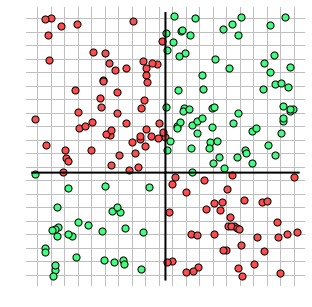

In [59]:
# make instance of warper
demo = warper2()

from sympy import symbols, lambdify, sin, cos, tanh, exp, log, Max
x1,x2 = symbols('x1 x2')
rule1 = x1*x2
rule2 = x1
demo.define_rule(rule1,rule2)
demo.make_pts()
demo.show_before_picture()

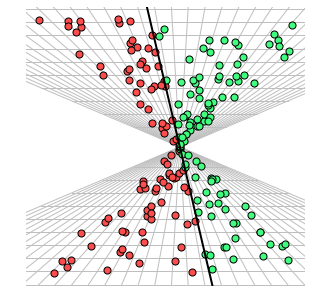

In [85]:
demo.transformation_slider()

In [61]:
np.shape(demo.grid)

(16000, 2)

# Generate a set of test contours.

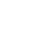

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import _cntr as cntr

r = np.linspace(-10.1,10.1,2000)
s,t = np.meshgrid(r,r)

# plot this EXTREMELY small - hack around the fact that you have to actually produce the plot to get the contour
fig = plt.figure(figsize = (0.02,0.02));  # looks like this is as small as you can make the figure without throwing an error, figsize dimensinos can be as small as 0.02 it seems
ax = fig.add_subplot(111);        # panel for original space
ax.axis('off');

# loop over
data = []
contours = []
for i in np.linspace(1,10,10):
    z = np.sin(s + 0.1*i)
    
    ##### how to grab contour without plotting it first
    # the cntr command grabs a contour without plotting it
    c = cntr.Cntr(s, t, z)
    res = c.trace(0)         # here trace grabs a contour at slice z = value
    cont = []
    for k in range(int(len(res)/float(2))):
        data = res[k]            # extract the right array from the trace object
        cont.append(data)

    
    ##### how to grab contour after plotting it
    ### to get each contour we must - it seems - actually plot it.  So we plot it completely transparent, and with no axis
#     c = ax.contour(s,t,z,colors='k', linewidths=2.0,levels = [0],alpha=0.0)  
    
#     # grab points of contour
#     p = c.collections[0].get_paths()[0]
#     v = p.vertices
#     x = v[:,0]
#     x.shape = (len(x),1)
#     y = v[:,1]
#     y.shape = (len(y),1)
#     data = np.concatenate((x,y),axis = 1)
    
    
    contours.append(cont)
    
# save contours as numpy array
contours = np.asarray(contours)
np.save('test_contours',contours)

In [95]:
len(contours[0])

7

# Test bokeh plotting.

In [79]:
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
from bokeh.palettes import Spectral11
output_notebook()

from ipywidgets import interact
import numpy as np

# create figure
p = figure(title="warp it", plot_height=400, plot_width=400, x_range = (-5,5),y_range=(-5,5))

## initialize properties of figure
# p.axis.visible = False
# p.xgrid.grid_line_color = None
# p.ygrid.grid_line_color = None

## initialize contour

## uncomment for single contour
# contours = np.load('test_contours.npy')
# data = contours[0]
# x = data[:,0]
# y = data[:,1]
# r = p.line(x, y, color="#2222aa", line_width=3)

# uncomment for multiple contours
contours = np.load('test_contours.npy')
r = p.multi_line(xs=[v[:,0] for v in contours[0]],ys = [v[:,1] for v in contours[0]], color="#000000", line_width=5)

## initialize scatter
d = 10*np.random.rand(200,2) - 5
q = p.circle(d[:,0],d[:,1],color ="#00FF7F",line_color = "#000000",size = 8,line_width = 1)

## initialize grid
numlines = 10

# initialize x values
t = np.linspace(-3,3,20)
t.shape = (len(t),1)
c = np.repeat(t,numlines,axis = 1)

# initialize y values
grid = np.random.rand(20,numlines)

# initialize multi-line   "#DD1C77" -- a nice red   "#7FC97F" -- a nice green   "#D3D3D3" -- light gray   "#000000" -- black
s = p.multi_line(xs=[v for v in c.T],ys = [g for g in grid.T] , line_color='#D3D3D3', line_width=3)


# update func
def update(f, w=0):
    # update contour
#     data = contours[w]
#     x = data[:,0]
#     y = data[:,1]
#     r.data_source.data = dict(x=x, y=y)    
    
    # multiple contours
    data = contours[w]
    
    xs =  [e[:,0] for e in data]
    ys = [e[:,1] for e in data]
    data = dict(xs=xs, ys=ys)
    r.data_source.data = data


    # update scatter
    d = 10*np.random.rand(200,2) - 5
    x = d[:,0]
    y = d[:,1]
    q.data_source.data = dict(x=x, y=y) 
    
    ## update grid
    # update y values
    grid = np.random.rand(200,numlines)
    
    # update mult-line
    s.data_source.data['ys'] = [g for g in grid.T] 
    
    # update figure range
    p.x_range.start = -5 
    p.x_range.end = 5
    p.y_range.start = -5
    p.y_range.end = 5
    
    # obligatory line to plot in notevook
    push_notebook()
    
show(p, notebook_handle=True)

Loading BokehJS ...

In [75]:
interact(update, f=["sin"], w=(0,9,1))

In [12]:
len(contours)

10

In [35]:
data = contours[5]
print [e[:,1] for e in data]


[array([-10.1       , -10.08989495, -10.07978989, ...,  10.07978989,
        10.08989495,  10.1       ]), array([-10.1       , -10.08989495, -10.07978989, ...,  10.07978989,
        10.08989495,  10.1       ]), array([-10.1       , -10.08989495, -10.07978989, ...,  10.07978989,
        10.08989495,  10.1       ]), array([-10.1       , -10.08989495, -10.07978989, ...,  10.07978989,
        10.08989495,  10.1       ]), array([-10.1       , -10.08989495, -10.07978989, ...,  10.07978989,
        10.08989495,  10.1       ]), array([-10.1       , -10.08989495, -10.07978989, ...,  10.07978989,
        10.08989495,  10.1       ]), array([-10.1       , -10.08989495, -10.07978989, ...,  10.07978989,
        10.08989495,  10.1       ])]


# Testing contour without plotting

In [19]:
from matplotlib import _cntr as cntr

In [77]:
r = np.linspace(-10.1,10.1,2000)
s,t = np.meshgrid(r,r)
z = np.sin(s) 

c = cntr.Cntr(s, t, z)
res = c.trace(0)         # here trace grabs a contour at slice z = value
data = res[0]            # extract the right array from the trace object

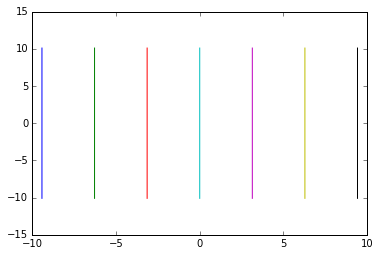

In [82]:
for k in range(int(len(res)/float(2))):
    data = res[k]
    plt.plot(data[:,0],data[:,1])

In [80]:
len(res)

14

In [81]:
res

[array([[ -9.42477798, -10.1       ],
        [ -9.42477798, -10.08989495],
        [ -9.42477798, -10.07978989],
        ..., 
        [ -9.42477798,  10.07978989],
        [ -9.42477798,  10.08989495],
        [ -9.42477798,  10.1       ]]), array([[ -6.28318532, -10.1       ],
        [ -6.28318532, -10.08989495],
        [ -6.28318532, -10.07978989],
        ..., 
        [ -6.28318532,  10.07978989],
        [ -6.28318532,  10.08989495],
        [ -6.28318532,  10.1       ]]), array([[ -3.14159266, -10.1       ],
        [ -3.14159266, -10.08989495],
        [ -3.14159266, -10.07978989],
        ..., 
        [ -3.14159266,  10.07978989],
        [ -3.14159266,  10.08989495],
        [ -3.14159266,  10.1       ]]), array([[  0.        , -10.1       ],
        [  0.        , -10.08989495],
        [  0.        , -10.07978989],
        ..., 
        [  0.        ,  10.07978989],
        [  0.        ,  10.08989495],
        [  0.        ,  10.1       ]]), array([[  3.14159266, -10.1